<a href="https://colab.research.google.com/github/EmmanuelADAM/IntelligenceArtificiellePython/blob/master/SolutionDetectionAlertes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Détection d'alertes par réseaux de neurones

Dans cet exercice, le but est de créer un systèmes très basique de détection de messages douteux  par Réseaux de Neurones en se basant uniquement sur des mots clés trouvés dans les sujets de mails.

Une version plus évoluée étudierait aussi le texte transormé en sac de mots.


---
*L’observation du contenu des communications par les gouvernements dans un but de sécurité permettrait de détecter les mails potentiellement dangereux et de lever des alertes.
Cependant la masse d’information échangée est trop importante pour garantir une bonne analyse.
Des réseaux de neurones peuvent être utilisés pour guider la détection de problèmes potentiels.*

*Il s’agit donc ici de définir un réseau de neurones et de lui faire apprendre à détecter des textes à risque.*

---

Les exemples d’apprentissage seront constitués :
- d’une série de valeurs indiquant si oui ou non un terme est présent dans le texte analysé,
- de la réponse attendue (dans la ligne danger)

Voici les exemples d’apprentissage :

| bombe | feu | fille | canon | mec | acide  | kalash | clip | balle | tennis | *danger* |
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
| 1 | 1 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 1 |
| 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 0 | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0 | 0 | 1 |
| 0 | 1 | 0 | 0 | 0 | 1 | 0 | 0 | 0 | 0 | 1 |
| 0 | 0 | 1 | 1 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 0 | 0 | 1 | 0 | 0 | 1 | 0 | 0 | 0 | 0 | 1 |
| 0 | 0 | 0 | 1 | 0 | 0 | 0 | 0 | 1 | 0 | 1 |
| 0 | 0 | 0 | 1 | 1 | 0 | 0 | 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 | 1 | 1 | 0 | 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 | 0 | 0 | 1 | 0 | 1 | 0 | 1 |
| 1 | 0 | 0 | 0 | 0 | 0 | 0 | 1 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 | 0 | 0 | 1 | 1 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 1 | 1 | 1 |
| 0 | 0 | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 1 | 1 |

---
## Importer les librairires

In [3]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
#pour les graphiques
import matplotlib.pyplot as plt
#SI bug plus loin lors du dessin des graphiques, ajouter ces 2 lignes
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

---

### Définir les entrées et sorties attendues

Les entrées correspondent aux présente des mots clés par sujet de mail.
Ici, les entrées d'apprentissage sont consituées de 70% de l'exemple présenté (donc 9 lignes de  13 valeurs 0,1). Les sorties d'apprentissage correspondent au fait que chaque entrée soit un spam ou non.

Les entrées et sorties de validations sont donc constitués des 40% restants


In [68]:
#transformer les données en entrées et sorties
tableau = np.array([
[ 1 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 ],
[ 1 , 0 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
[ 0 , 1 , 0 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 1 ],
[ 0 , 1 , 0 , 0 , 0 , 1 , 0 , 0 , 0 , 0 , 1 ],
[ 0 , 0 , 1 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
[ 0 , 0 , 1 , 0 , 0 , 1 , 0 , 0 , 0 , 0 , 1 ],
[ 0 , 0 , 0 , 1 , 0 , 0 , 0 , 0 , 1 , 0 , 1 ],
[ 0 , 0 , 0 , 1 , 1 , 0 , 0 , 0 , 0 , 0 , 0 ],
[ 0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 1 , 0 , 1 ],
[ 0 , 0 , 0 , 0 , 0 , 0 , 1 , 1 , 0 , 0 , 0 ],
[ 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 1 , 1 ]], float)

#on prend un pourcentage de lignes pour apprendre, le reste pour valider
#il faut mélanger les lignes pour pouvoir avoir des exemples d'apprentissage
# et de validation homogènes
np.random.shuffle(tableau)

#on décide que 70% des lignes sont des lignes d'apprentissage
nb_lignes = tableau.shape[0]
nb_lignes_app = nb_lignes * 70 // 100
nb_lignes_val = nb_lignes - nb_lignes_app

# les 10 premieres colonnes sont les entrees
entrees_app = np.zeros((nb_lignes_app, 10), float)
entrees_val = np.zeros((nb_lignes_val, 10), float)

# la derniere colonne est la sortie
sorties_app = np.zeros((nb_lignes_app, 1), float)
sorties_val = np.zeros((nb_lignes_val, 1), float)

#on remplit ces exemples d'apprentissage et de validation
for i in range(0,nb_lignes_app):
    entrees_app[i] = tableau[i][0:10]
    sorties_app[i] = tableau[i][10:]

#on remplit ces exemples de validation
for i in range(0, nb_lignes_val):
    entrees_val[i] = tableau[nb_lignes_app+i][0:10]
    sorties_val[i] = tableau[nb_lignes_app+i][10:]

---

### Choisir le modèle de réseau
- ici les couches sont séquentielles

In [73]:
model = Sequential()

---

### Définir l'architecture du réseau
Choisissez la struture du réseau, le nb de couches cachées, etc.
- une première couche composée de 
  - 11 neurones en entrée , plus le neurone BIAS (ou non)
  - x neurones en sortie 
- une couche composée
  - y neurones en entrée (ceux de la couche précédente) et 
  - de 1 neurone en sortie (Spam ou non)


In [74]:
#une premiere couche constituée de 10 neurones en entrée, 4 en sortie...
model.add(Dense(8, use_bias=True, input_shape=(10,), activation='sigmoid'))

model.add(Dense(5,  use_bias=True, activation='sigmoid'))

#une derniere couche constituée de 1 neurone en sortie, 
# nb neurones de la couche précédente en entrée et activation sigmoide
model.add(Dense(1, activation='tanh'))

---

### Compiler le  réseau
- ici, on précise que l'algo de correction d'erreur est *'adam'*, et que l'erreur calculée est la moyenne des valeurs absolues des erreurs commises. On indique également que l'on veut voir apparaître en plus la précision de l'apprentissage (accuracy).

(vous pouvez chosir un autre optimizer et un autre clacul de loss)

In [75]:
model.compile(optimizer='adam', loss='MSE', metrics=['accuracy'])

---

### Entraîner le réseau 
- ici on  le fait  'parler' (verbose=2) si le nb de cycles d'apprentissage (epochs) est court


In [76]:
tests = model.fit(entrees_app, sorties_app, 
                    validation_data=(entrees_val, sorties_val),
                    epochs=500, verbose=0)

---

## Dessiner l'évolution de l'erreur et de la pertinence


In [77]:
history_dict = tests.history
eval_tests = list(history_dict.keys())
print("les ensembles de valeurs récupérées lors des tests sont ")
print(eval_tests)
print("-> [perte sur exemple d'entrainement, qualité sur exemples d'entrainement,perte sur exemple de validation, qualité sur exemples de validation]")


les ensembles de valeurs récupérées lors des tests sont 
['loss', 'accuracy', 'val_loss', 'val_accuracy']
-> [perte sur exemple d'entrainement, qualité sur exemples d'entrainement,perte sur exemple de validation, qualité sur exemples de validation]


#### Tracer l'erreur d'entrainement / l'erreur de validation
- L'erreur d'entrainement et l'erreur de validation doivent suivre des courbes quasi parallèle.
- L'erreur d'entrainement doit être plus faible que l'erreur de validation
    - si les courbes divergent, si la courbe de validation s'éloigne de la courbe d'entrainement, il y a alors un sur-apprentissage (overfitting) trop adapté aux données d'entrainement, sans doute trop poussé (diminuer les epochs?).
    - s'il y a une erreur d'entrainement trop grande, il y a sous-apprentissage

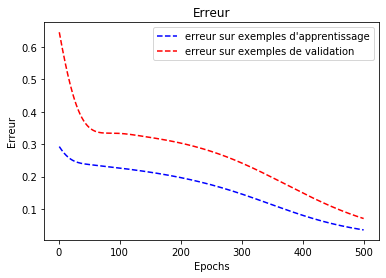

In [78]:
import matplotlib.pyplot as plt

loss = history_dict[eval_tests[0]]
val_loss = history_dict[eval_tests[2]]

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, loss, 'b--', label='erreur sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_loss, 'r--', label='erreur sur exemples de validation')
plt.title('Erreur')
plt.xlabel('Epochs')
plt.ylabel('Erreur')
plt.legend()

plt.show()

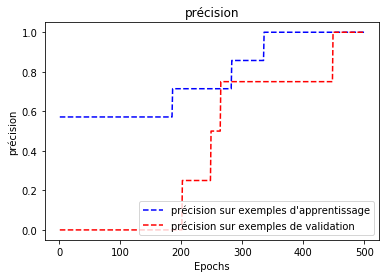

In [79]:
acc = history_dict[eval_tests[1]]
val_acc = history_dict[eval_tests[3]]

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, acc, 'b--', label='précision sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_acc, 'r--', label='précision sur exemples de validation')
plt.title('précision')
plt.xlabel('Epochs')
plt.ylabel('précision')
plt.legend()

plt.show()

---
## Utilisation du réseau
Quelle est la probabilité que les textes contenant les mots :
1. clip acide
2. mec fille canon
3. kalash bombe

soient des textes suspects ?

In [80]:
entreesTests = np.array([
[ 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
[ 0, 0, 1, 1, 1, 0, 0, 0, 0, 0 ],
[ 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]], float)


predictions = model.predict(entreesTests)
print(predictions)

[[ 0.6291229 ]
 [-0.22783169]
 [ 0.18259093]]


---
### Correction des exemples

On détecte alors que le texte contenant les mots « clip » et « acide » est suspect à plus de 95% et que le texte contenant les mots « bombe » et « kalash » ne l’est qu’à 45%.

Ajouter les lignes aux exemples d’entrainement permettant d’ôter le premier texte de la ligne des suspects et d’ajouter le second dans cette liste de suspects.

Relancer l’apprentissage du réseau et vérifier que les textes sont bien classés.